# Ilford Delta 3200

Notebook for extracting film pigment and experimenting with layers to get the right balancing.

## Film Pigment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

In [2]:
film_image = "Films/DELTA_3200.png"

### Load film image & preprocess

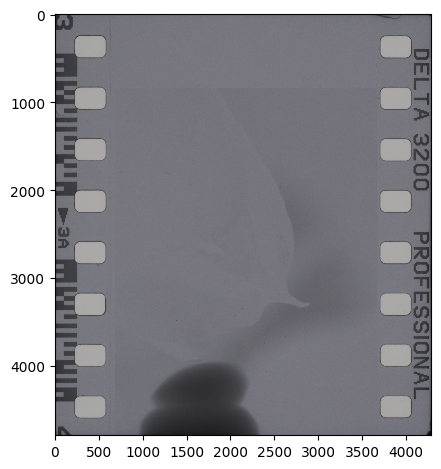

In [3]:
image = ski.util.img_as_float64(ski.io.imread(film_image))
ski.io.imshow(image)

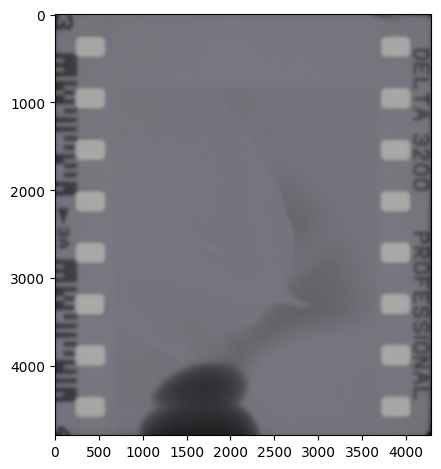

In [4]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [5]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [6]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

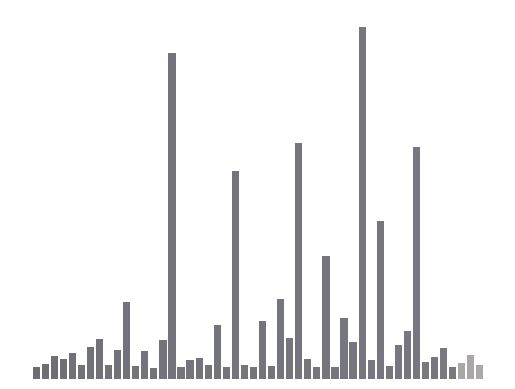

In [7]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [8]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-4]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (170, 168, 168)
Emulsion value: (121, 120, 128)


### Preprocess `emulsion` to get pigment

In [27]:
%autoreload 2

In [9]:
from nevernegative.layers.balancing.temperature import Temperature

pigment = (emulsion * 255 / white).astype(np.uint8)
temperature = Temperature.infer_temperature(white)

print(f"Pigment value: {tuple(pigment.tolist())}")
print(f"Estimated white temperature: {temperature:.0f}K.")


Pigment value: (181, 182, 194)
Estimated white temperature: 6443K.


(np.float64(-0.5), np.float64(4288.5), np.float64(4793.5), np.float64(-0.5))

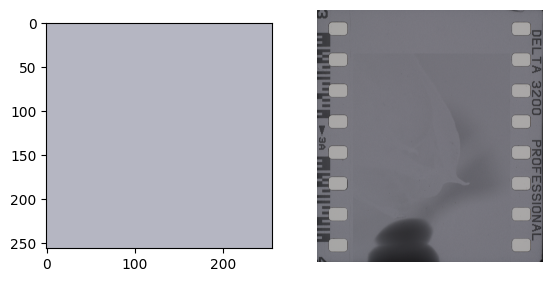

In [10]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image, cmap="gray")

plt.axis("off")

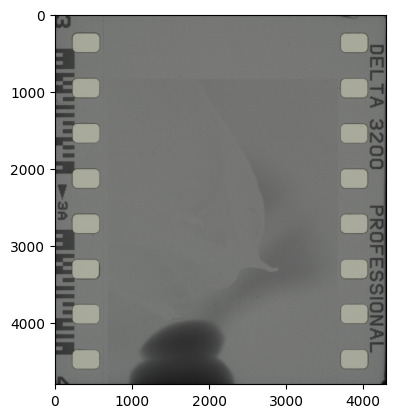

In [11]:
import torch
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment

temperature_layer = Temperature(6440)
emulsion_layer = RemoveEmulsionPigment(pigment=(201, 202, 217), brightness_correction=True, mode="divide")
image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

plt.imshow(emulsion_layer(temperature_layer(image_tensor)).permute(1, 2, 0), cmap="gray")


## Layers

In [1]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt

In [2]:
images_folder = "/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Liverpool Delta 3200"
glob = "*.NEF"

### V1: Removing Emulsion Pigment

In [7]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.grey import Grey
from nevernegative.layers.utils.clip import Clip
from nevernegative.layers.balancing.invert import Invert

layers = [
    Temperature(temperature=5000),
    RemoveEmulsionPigment(pigment=(181, 182, 194), brightness_correction=True),
    Invert(),
    Grey(channel=2),
    # Brightness(1.2),
    # Contrast(1.2),
    Clip(),
]

### Testing Layers

#### Single Image

(np.float64(-0.5), np.float64(265.5), np.float64(399.5), np.float64(-0.5))

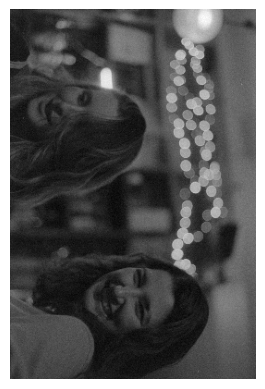

In [8]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "DSC_1299.NEF"
output_path = Path("results/delta_3200/")

processed = scanner.file(
    source=Path(images_folder) / filename,
    destination=Path("results/delta_3200/"),
    is_raw=True,
    plot_path=output_path
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")

In [ ]:
scanner = SimpleScanner(layers, device="mps")

scanner.glob(
    source=(Path(images_folder) / glob).as_posix(),
    destination=Path("test_images/delta_3200"),
    is_raw=True,
)

Proccesing images: 100%|██████████| 33/33 [09:04<00:00, 16.50s/it]


: 